In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install tqdm
!pip install torchmetrics
# !pip install torch.ignite

In [3]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
from tokenizers import BertWordPieceTokenizer
from nltk.corpus import stopwords
from nltk import pad_sequence
import os
import torch
from nltk import word_tokenize
import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from torchmetrics.classification import BinaryPrecision, BinaryRecall, BinaryConfusionMatrix, F1Score, Accuracy

In [4]:
def data_curation(positive_samples, negative_samples):
  ps = torch.load(positive_samples)
  ns = torch.load(negative_samples)
  df = pd.DataFrame(columns = ['datalake', 'query', 'label'])

  new_ps, new_ns = [], []
  for i in ps:
    if torch.isnan(i[0]).any() and torch.isinf(i[0]).any():
      continue
    elif torch.isnan(i[1]).any() and torch.isinf(i[1]).any():
      continue
    else:
      new_ps.append(i)
  for i in ns:
    if torch.isnan(i[0]).any() and torch.isinf(i[0]).any():
      continue
    elif torch.isnan(i[1]).any() and torch.isinf(i[1]).any():
      continue
    else:
      new_ns.append(i)
  datalake = [i[0] for i in new_ps] + [i[0] for i in new_ns]
  query= [i[1] for i in new_ps] + [i[1] for i in new_ns]
  labels = [1 for _ in range(len(new_ps))] + [0 for _ in range(len(new_ns))]

  df['datalake'] = datalake
  df['query'] = query
  df['label'] = labels

  return df


  

In [5]:
pos_file = "/content/drive/MyDrive/labeled_benchmark/embeddings.pt"
neg_file = "/content/drive/MyDrive/labeled_benchmark/zero_embedding.pt"
df = data_curation(pos_file, neg_file)

In [6]:
df.head()

,datalake,query,label
0,"[[[tensor(1.0432), tensor(-0.0083), tensor(-0....","[[[tensor(1.0432), tensor(-0.0083), tensor(-0....",1
1,"[[[tensor(1.0630), tensor(-0.0105), tensor(-0....","[[[tensor(0.9999), tensor(-0.0096), tensor(-0....",1
2,"[[[tensor(1.0432), tensor(-0.0083), tensor(-0....","[[[tensor(1.0432), tensor(-0.0083), tensor(-0....",1
3,"[[[tensor(1.2163), tensor(-0.0029), tensor(-0....","[[[tensor(1.0432), tensor(-0.0083), tensor(-0....",1
4,"[[[tensor(1.1730), tensor(-0.0043), tensor(-0....","[[[tensor(0.9999), tensor(-0.0096), tensor(-0....",1


In [7]:
cos = torch.nn.CosineSimilarity(dim=0)

similarity = cos(df.datalake.iloc[48] , df['query'].iloc[48])

In [8]:
similarity.mean()

tensor(0.9846)

In [9]:
x = df.drop('label', axis = 1)
y = df.drop(['datalake', 'query'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 52)

In [10]:
y_test

,label
2,1
8,1
19,1
66,0
52,0
4,1
29,1
80,0
51,0


In [11]:
e = torch.empty(size = [80, 512, 768])
q = torch.empty(size = [80, 512, 768])
la = torch.empty(size = [80, 512, 768])
for i in x_train.datalake.values:
  torch.cat((e, i))
for i in x_train['query'].values:
  torch.cat((q, i))
y_tens = torch.tensor([y_train.label.values.T])
inp = torch.cat((e, q))

<ipython-input-11-f2f9271245df>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  y_tens = torch.tensor([y_train.label.values.T])


In [12]:
e_test = torch.empty(size = [9, 512, 768])
q_test = torch.empty(size = [9, 512, 768])
lab_test = torch.empty(size = [9, 512, 768])

for i in x_test.datalake.values:
  torch.cat((e_test, i))
for i in x_test['query'].values:
  torch.cat((q_test, i))
test_tens = torch.tensor([y_test.label.values.T])
test_inp = torch.cat((e_test, q_test))

In [13]:
y_tens.size()

torch.Size([1, 80])

In [14]:
import torch
import torch.nn as nn

n_input, n_hidden, n_out, learning_rate = 768, 512, 1, 0.005
model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(512, 150),
                      nn.ReLU(),
                      nn.Linear(150, n_out),
                      nn.Sigmoid())
print(model)

Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=150, bias=True)
  (3): ReLU()
  (4): Linear(in_features=150, out_features=1, bias=True)
  (5): Sigmoid()
)


In [15]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
losses = []
y_temp = torch.cat((y_tens, y_tens), dim=-1).T
# print(inp.size())
pred_y = 0
for epoch in range(10):
  # for (idx, batch) in enumerate(DL_DS):
    pred_y = model(inp)
    loss = loss_function(pred_y, y_temp)
    losses.append(loss.item())

    model.zero_grad()
    loss.backward()
    optimizer.step()



In [18]:
losses

[6.232572078704834,
 6.231419563293457,
 6.229737281799316,
 6.229144096374512,
 6.228337287902832,
 6.2272047996521,
 6.22592830657959,
 6.224761009216309,
 6.223835468292236,
 6.223099231719971]

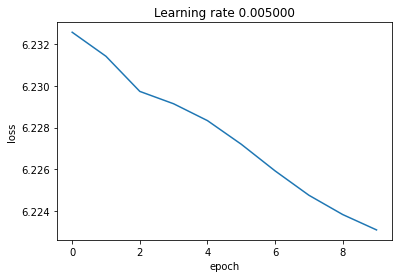

In [19]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [20]:
def cosine_sim(tab1, tab2, threshold):
  union = 0
  cos = torch.nn.CosineSimilarity(dim=0)

  similarity = cos(tab1, tab2)
  if similarity.mean() <= threshold:
    union = 0
  else: union = 1

  return union

In [21]:
def evaluate(y_true, pred_val):

  bin_prec = BinaryPrecision()
  bin_recall = BinaryRecall()
  bin_cm = BinaryConfusionMatrix()
  f1 = F1Score(task="binary")
  acc = Accuracy(task="binary")
  prec = bin_prec(torch.tensor(y_true), torch.tensor([pred_val]).T)
  rec = bin_recall(torch.tensor(y_true), torch.tensor([pred_val]).T)
  cm = bin_cm(torch.tensor(y_true), torch.tensor([pred_val]).T)
  f1_score = f1(torch.tensor(y_true), torch.tensor([pred_val]).T)
  accuracy = acc(torch.tensor(y_true), torch.tensor([pred_val]).T)
  print(f'precision: {prec}\nrecall:{rec}\nConfusion Matrix: {cm} \nF1-Score: {f1_score} \naccuracy: {accuracy}')

In [22]:
#precision of train data - Cosine similarity
y_eval = []
for i in range (len(x_train)):
  y_eval.append(cosine_sim(x_train.datalake.iloc[i], x_train['query'].iloc[i], 0.985))

evaluate(y_train.values.tolist(), y_eval)

precision: 0.8780487775802612
recall:0.5070422291755676
Confusion Matrix: tensor([[ 4,  5],
        [35, 36]]) 
F1-Score: 0.6428571343421936 
accuracy: 0.5


In [23]:
#precision of train data - Cosine similarity
y_eval = []
for i in range (len(x_train)):
  y_eval.append(cosine_sim(x_train.datalake.iloc[i], x_train['query'].iloc[i], 0.981))

evaluate(y_train.values.tolist(), y_eval)

precision: 0.9268292784690857
recall:0.5135135054588318
Confusion Matrix: tensor([[ 3,  3],
        [36, 38]]) 
F1-Score: 0.6608695387840271 
accuracy: 0.512499988079071


In [24]:
#precision of train data - Cosine similarity
y_eval = []
for i in range (len(x_train)):
  y_eval.append(cosine_sim(x_train.datalake.iloc[i], x_train['query'].iloc[i], 0.998))

evaluate(y_train.values.tolist(), y_eval)

precision: 0.6097561120986938
recall:0.46296295523643494
Confusion Matrix: tensor([[10, 16],
        [29, 25]]) 
F1-Score: 0.5263158082962036 
accuracy: 0.4375


In [25]:
#precision of test data - Cosine similarity
y_eval = []
for i in range (len(x_test)):
  y_eval.append(cosine_sim(x_test.datalake.iloc[i], x_test['query'].iloc[i], 0.981))

evaluate(y_test.values.tolist(), y_eval)

precision: 1.0
recall:0.5555555820465088
Confusion Matrix: tensor([[0, 0],
        [4, 5]]) 
F1-Score: 0.7142857313156128 
accuracy: 0.5555555820465088


In [26]:
#precision of test data - Cosine similarity
y_eval = []
for i in range (len(x_test)):
  y_eval.append(cosine_sim(x_test.datalake.iloc[i], x_test['query'].iloc[i], 0.989))

evaluate(y_test.values.tolist(), y_eval)

precision: 0.800000011920929
recall:0.5
Confusion Matrix: tensor([[0, 1],
        [4, 4]]) 
F1-Score: 0.6153846383094788 
accuracy: 0.4444444477558136


In [27]:
# evaluation metrics - Deep learning model
f = []
for i in pred_y:
  if i.mean()<= 0.05:
    f.append(torch.tensor(0))
  else: f.append(torch.tensor(1))

y_t = y_train.values.tolist()
for i in y_train.values.tolist():
  y_t.append(i)

evaluate(y_t, f)

precision: 0.3048780560493469
recall:0.625
Confusion Matrix: tensor([[63, 57],
        [15, 25]]) 
F1-Score: 0.4098360538482666 
accuracy: 0.550000011920929


In [28]:
f = []
for i in pred_y:
  if i.mean()<= 0.09:
    f.append(torch.tensor(0))
  else: f.append(torch.tensor(1))

y_t = y_train.values.tolist()
for i in y_train.values.tolist():
  y_t.append(i)

evaluate(y_t, f)


precision: 0.3048780560493469
recall:0.625
Confusion Matrix: tensor([[63, 57],
        [15, 25]]) 
F1-Score: 0.4098360538482666 
accuracy: 0.550000011920929


In [29]:
f = []
for i in pred_y:
  if i.mean()<= 0.098:
    f.append(torch.tensor(0))
  else: f.append(torch.tensor(1))

y_t = y_train.values.tolist()
for i in y_train.values.tolist():
  y_t.append(i)

evaluate(y_t, f)

precision: 0.0
recall:0.0
Confusion Matrix: tensor([[78, 82],
        [ 0,  0]]) 
F1-Score: 0.0 
accuracy: 0.48750001192092896
